# Statistical Learning with DNN: Task 2

### Álvaro Capel & Enric Alavedra

#### Loading Libraries

LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente (RNN) usada para secuencias de datos (texto o series temporales, básicamente):

Características del LSTM:
- Memoria a largo plazo: tienen una estructura interna que decide la información que se conserva y la que se olvida
- Útiles para capturar dependencias a lo largo del tiempo (eso permite que una palabr que está en el principio ifluye en el final)

Características del Bidirectional LSTM: 
- Hay dos LSTM: una que va de inicio a fin y otra que va de fin a inicio; luego los resultados de ambas se combinan
- En estos casos, se tiene que usar BiLSTM porque en temas de texto, el contexto futuro y pasado es importante

RNN: la gran diferencia con las redes tradicionales, las RNN tienen memoria (es decir, recuerda la información de pasos anteriores para procesar el siguiente paso)

Explicación de las librerías y funciones asociadas:
- pandas; numpy: manipulación de datos
- tensorflow.keras: crear redes neuronales profundas 
- Tokenizer; pad_sequences: procesamiento de texto (funciones de la librería tensorflow)
- Embedding, LSTM, Dense, etc: contrucción del modelo de red neuronal que incluyen capas LSTM direccional
- ModelCheckpoint: guardar automáticamente el mejor modelo entrenado
- to_categorical: convertir etiquetas numéricas a one-hot encoding

In [3]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

#### Exercise 1: calculate the average length of the symptoms in the dataset 

Estamos calculando la longitud media de todos los síntomas, no agrupando por enfermedades

In [3]:
def calculate_avg_length(data):
    return data['text'].str.split().str.len().mean()
data = pd.read_csv("Symptom2Disease.csv")
avg_length = calculate_avg_length(data)
print(f"Average symptom length: {avg_length:.2f} words")

Average symptom length: 30.73 words


#### Exercise 2: Set a 5000 words dictionary. Tokenization of symptons using keras

Al tokenizar las palabras de los síntomas, el texto se convierte en secuencias numéricas. 

El paso de padding sirve para igualar la longitud de las secuencias

Finalmente, los labels (enfermedades) se les hace un one-hot encoding

In [4]:
max_words = 5000
max_length = int(np.ceil(avg_length))  # We have decided to use an upper rounding
# Tokenization Process
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['text']) 
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length)
# Convert labels to categorical
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'])
num_classes = len(label_encoder.classes_)
y = to_categorical(labels)

#### Exercise 3: Split data in 2/3 for training and 1/3 for testing

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
        padded_sequences, y, test_size=1/3, random_state=123
)

#### Exercise 4: Implement a BiLSTM model for disease prediction

Input: una secuencia de texto que ya está tokenizada

Embedding: transforma las palabras en vectores densos. Cada palabra del texto se representa como un vector de 128 dimensiones (es el estándard)

BiLSTM: procesa el texto hacia adelante y atrás
La LSTM tiene 64 unidades ocultas en cada dirección (al ser bidireccional, la salida total es de 128) (escoger 64 es porque es suficientemente grande como para capturar patrones complejos pero no tan grande como para volverse difícil de entrenar)

Dense + Dropout: capas intermedias (evitar overfitting)

Output: capa softmax para clasificación según las enfermedades

C:\Users\usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 31, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,632 (2.86 MB)

 Trainable params: 748,632 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.0617 - loss: 3.1710 - val_accuracy: 0.1375 - val_loss: 3.1366
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1113 - loss: 3.0892 - val_accuracy: 0.1125 - val_loss: 2.9246
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1473 - loss: 2.8445 - val_accuracy: 0.3250 - val_loss: 2.5803
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2162 - loss: 2.5026 - val_accuracy: 0.4625 - val_loss: 2.1318
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3511 - loss: 2.0295 - val_accuracy: 0.5938 - val_loss: 1.6727
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4470 - loss: 1.6126 - val_accuracy: 0.6562 - val_loss: 1.2804
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5913 - loss: 1.3034 - val_accuracy: 0.7188 - val_loss: 1.0682
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6715 - loss: 1.0172 - val_accuracy: 0.7812 - v

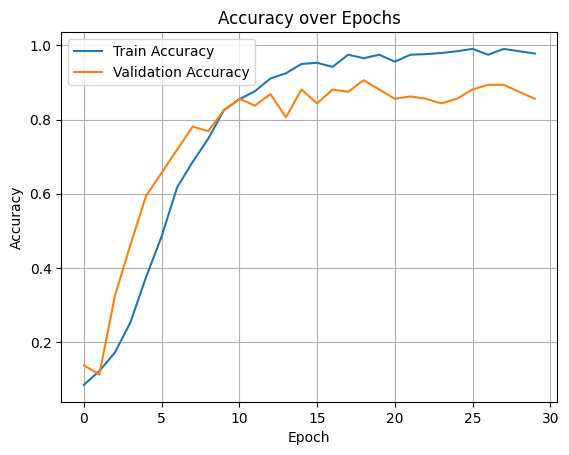

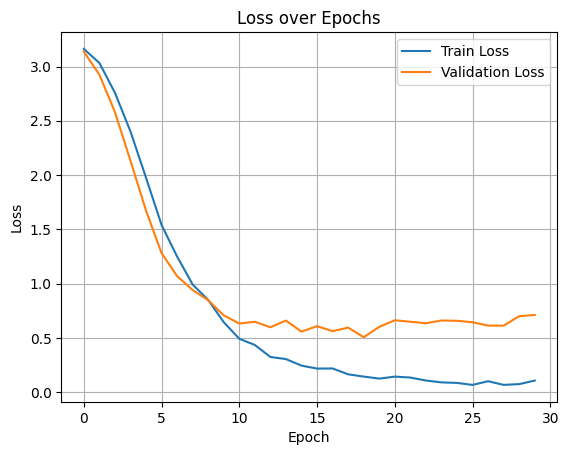

In [6]:
def create_bilstm_model():
    input_layer = Input(shape=(max_length,))
    embedding = Embedding(input_dim=max_words, output_dim=128, input_length=max_length)(input_layer)
    bilstm = Bidirectional(LSTM(64))(embedding)
    dense = Dense(64, activation='relu')(bilstm)
    dropout = Dropout(0.5)(dense)
    output = Dense(num_classes, activation='softmax')(dropout)
        
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model
# Configuration of the model
model = create_bilstm_model()
model.summary()   
# Training of the model
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)   
# Evaluation of the test set
results = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {results[1]:.4f}")
# Evolution graphs
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Exercise 5: Include a callback for saving the best model

Se guarda automáticamente el modelo que tenga mejor precisión de validación

Una vez el modelo con mejor precisión se guarda, se entrena el modelo otra vez, pero con el callback activado

Epoch 1/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0472 - loss: 3.1767

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.0494 - loss: 3.1762 - val_accuracy: 0.2625 - val_loss: 3.1481
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1577 - loss: 3.1239 - val_accuracy: 0.2313 - val_loss: 2.9402
Epoch 3/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1398 - loss: 2.8476

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1421 - loss: 2.8374 - val_accuracy: 0.3250 - val_loss: 2.3470
Epoch 4/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2495 - loss: 2.3722

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2485 - loss: 2.3691 - val_accuracy: 0.3938 - val_loss: 1.9764
Epoch 5/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3336 - loss: 2.0827

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3356 - loss: 2.0774 - val_accuracy: 0.4437 - val_loss: 1.6933
Epoch 6/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4095 - loss: 1.7796

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4111 - loss: 1.7737 - val_accuracy: 0.5813 - val_loss: 1.3930
Epoch 7/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5498 - loss: 1.4161

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5491 - loss: 1.4155 - val_accuracy: 0.6875 - val_loss: 1.1643
Epoch 8/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6188 - loss: 1.2143

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6185 - loss: 1.2139 - val_accuracy: 0.6938 - val_loss: 1.0268
Epoch 9/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7198 - loss: 0.9247

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7167 - loss: 0.9306 - val_accuracy: 0.7188 - val_loss: 0.9210
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7160 - loss: 0.8846 - val_accuracy: 0.7063 - val_loss: 0.8992
Epoch 11/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7740 - loss: 0.7421

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7752 - loss: 0.7367 - val_accuracy: 0.7437 - val_loss: 0.8052
Epoch 12/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8244 - loss: 0.6441

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8249 - loss: 0.6402 - val_accuracy: 0.8188 - val_loss: 0.6482
Epoch 13/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8910 - loss: 0.4351 - val_accuracy: 0.7875 - val_loss: 0.7374
Epoch 14/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8791 - loss: 0.4580

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8809 - loss: 0.4523 - val_accuracy: 0.8375 - val_loss: 0.6075
Epoch 15/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9366 - loss: 0.2911 - val_accuracy: 0.8250 - val_loss: 0.6076
Epoch 16/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9386 - loss: 0.2479 - val_accuracy: 0.8313 - val_loss: 0.5929
Epoch 17/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9361 - loss: 0.2818 - val_accuracy: 0.8375 - val_loss: 0.5744
Epoch 18/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9503 - loss: 0.2244 - val_accuracy: 0.8188 - val_loss: 0.6593
Epoch 19/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9452 - loss: 0.2202

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9457 - loss: 0.2179 - val_accuracy: 0.8500 - val_loss: 0.6479
Epoch 20/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9656 - loss: 0.1637 - val_accuracy: 0.8250 - val_loss: 0.8428
Epoch 21/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9486 - loss: 0.2059 - val_accuracy: 0.8062 - val_loss: 0.7749
Epoch 22/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9553 - loss: 0.1610

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9564 - loss: 0.1602 - val_accuracy: 0.8562 - val_loss: 0.5911
Epoch 23/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9709 - loss: 0.1401 - val_accuracy: 0.8125 - val_loss: 0.7914
Epoch 24/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9643 - loss: 0.1210 - val_accuracy: 0.7937 - val_loss: 1.0214
Epoch 25/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9530 - loss: 0.1516 - val_accuracy: 0.8000 - val_loss: 1.0167
Epoch 26/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9546 - loss: 0.1718

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9545 - loss: 0.1712 - val_accuracy: 0.8687 - val_loss: 0.5404
Epoch 27/30
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9781 - loss: 0.1153

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9781 - loss: 0.1178 - val_accuracy: 0.8750 - val_loss: 0.5210
Epoch 28/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9946 - loss: 0.0714 - val_accuracy: 0.8687 - val_loss: 0.5563
Epoch 29/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9925 - loss: 0.0592 - val_accuracy: 0.8625 - val_loss: 0.5799
Epoch 30/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9920 - loss: 0.0537 - val_accuracy: 0.8562 - val_loss: 0.6781


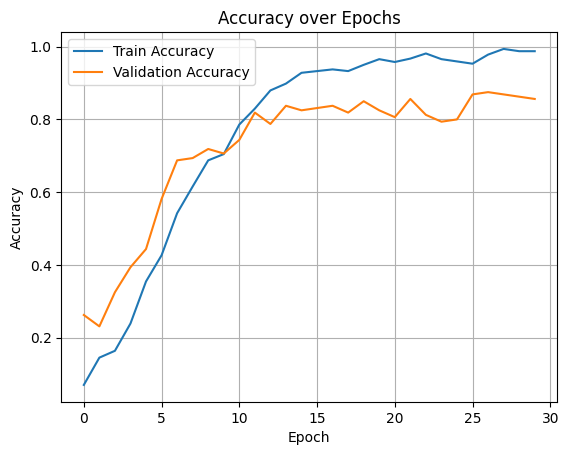

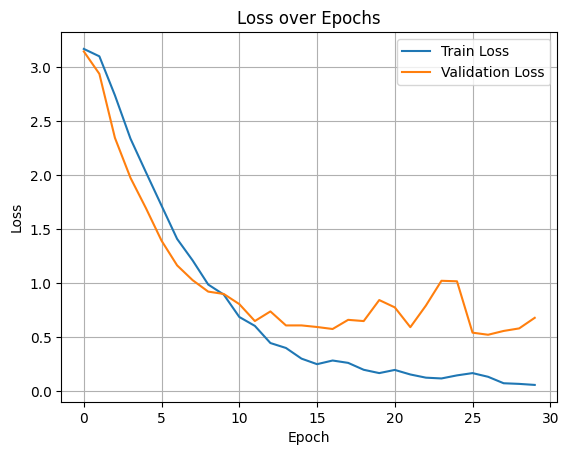

In [7]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
    
model = create_bilstm_model()  # Repetition of the creation of the model with new training method
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint]
)
# Evolution graphs
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Exercise 6: Accuracy of the test

Tener una accuracy del 80% (entre 70-90%) supone un buen resultado si el problema es complejo y las clases están equilibradas

In [8]:
# Getting the beest model from callback process
best_model = keras.models.load_model('best_model.h5')
results = best_model.evaluate(x_test, y_test)
print(f"Best Model Test Accuracy: {results[1]:.4f}")
# Predictions
preds = best_model.predict(x_test)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8170 - loss: 0.8231 
Best Model Test Accuracy: 0.8075
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


#### Exercise 7: Confusion matrix

Para entender la confusion matrix, los valores de la diagonal cuanto mayores sean mejor (son los aciertos: aquellas predicciones que se asignan correctamente al real). En cambio, los valores que están fuera de la diagonal, son errores

Como entender el Classification Report:
- Accuracy: de todas las veces que el modelo predijo una enfermedad específica, ¿cuántas veces acertó?
- Macro avg: de todas las veces que la predicción de la enfermedad es correcta, ¿cuántas veces la detectó?
- Weighted avg: promedio ponderado de precision y macro avg 

In [10]:
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))
    
print("\nClassification Report:")
print(classification_report(
    true_classes, pred_classes,
    target_names=label_encoder.classes_
))



Confusion Matrix:
[[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  2  0  0  0  0  0  1  0  0  0  2  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 14  0  1  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  3  0 11  0  0  0  0  0  0  0  0  0  2  1  0  1  1  1  0  0]
 [ 0  1  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0]
 [ 0  0  0  3  0  0  0  0  0 14  0  0  0  1  0  0  0  0  1  0  2  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  

#### Exercise 8: Conclusions (architecture, results, difficulties, etc.)

En relación a las conclusiones de los resultados: se ha llegado a un modelo que, al analizar es subgrupo de datos de entrenamiento, llega a una precisión del 85%. De las diferentes evaluaciones, el uso del callback permite guardar los resultados del mejor modelo.
<!-- /n -->
No obstante, al evaluar el set de testing, la precisión baja un poco, entorno al 80%. Aun así, se considera que es un modelo correcto y con buenos resultados, ya que una accuracy de ese valor para este tipo de situaciones es favorable. 
<!-- /n -->
El hecho que sí supone un resultado contradictorio y en contra del modelo es el valor de la loss, ya que como se puede observar en los gráficos aparece un plateau a medida que se va iterando el proceso.
<!-- /n -->
Finalmente, otro métrica que permite evaluar el modelo desarrollado son los resultados de la confusion matrix, la cual ofrece una matriz de predicciones que han sido asignadas correctamente (valores en la diagonal) y predicciones categorizadas erroneamente (fura de la diagona). Tal y como se informaba anteriormente con la métrica de la precisión, la capacidad del modelo de predecir valores de forma correcta está alrededor del 80%.
<!-- /n -->
<!-- /n -->
Hablando ahora de la arquitectura escogida: haber escogido un modelo BiLSTM es una decisión corrcta en el contexto trabajado, pues en la descipción de los síntomas de una enfermedad, por lo tanto, al analizar texto, es óptimo escoger un modelo de RNN. Además, en este caso, donde la información previa como la posterior tienen un grado significativo de relevancia, se requiere un tipo de RNN capaz de evaluar una palabra en función de las anteriores y posteriores. Es por este motivo que en este caso una BiLSTM es idoneo. No obstante, en el proceso de definición del modelo, aparecen ciertos hiperparámetros (en el Embeddding y en la deifnición del BiLSTM) que hemos establecido a partir del "State of Art" en estos casos, pero quizá sí puede ser una fuente de ineficiencia en los resultados. 
